In [54]:
import torch
import torch.autograd.functional as F
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [38]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
#plt.rcParams.update(bundles.icml2022())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'


In [39]:
import hamiltorch

In [40]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
device

device(type='cuda')

In [42]:
gt_distribution = torch.distributions.Normal(0, 1)

# Samples from the ground truth distribution
def sample_gt(n):
    return gt_distribution.sample((n,))

samples = sample_gt(1000)


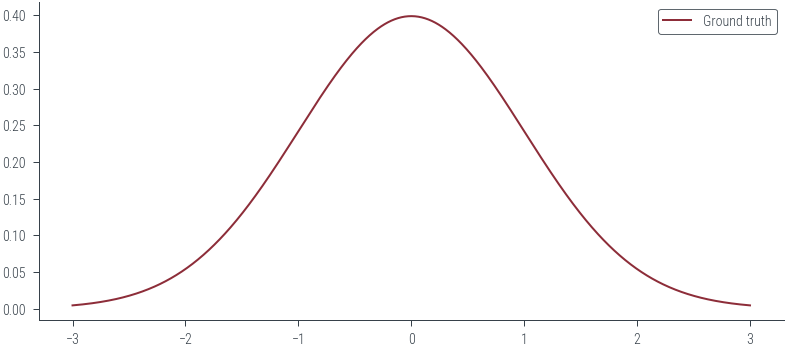

In [43]:
x_lin = torch.linspace(-3, 3, 1000)
y_lin = torch.exp(gt_distribution.log_prob(x_lin))

plt.plot(x_lin, y_lin, label='Ground truth')
plt.legend()

In [44]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return gt_distribution.log_prob(x)

In [45]:
logprob(torch.tensor([0.0]))

tensor([-0.9189])

In [46]:
# Initial state
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

In [47]:
params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,  
                               num_samples=num_samples, step_size=step_size, 
                               num_steps_per_sample=num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:07 | 0d:00:00:00 | #################### | 5000/5000 | 674.76       
Acceptance Rate 0.99


In [48]:
params_hmc = torch.tensor(params_hmc)

Text(0, 0.5, 'Parameter value')

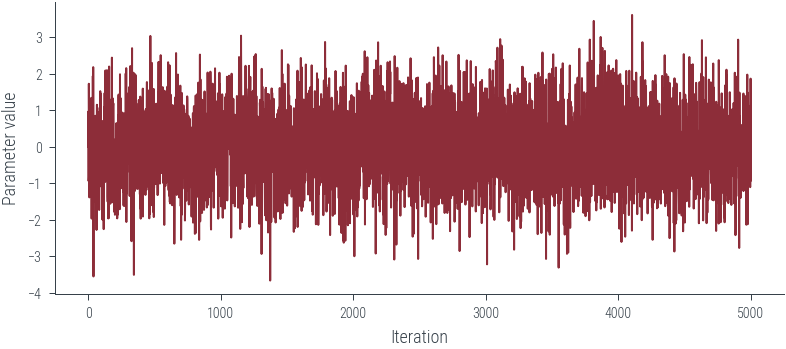

In [49]:
# Trace plot
plt.plot(params_hmc, label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')

Text(0, 0.5, 'Parameter value')

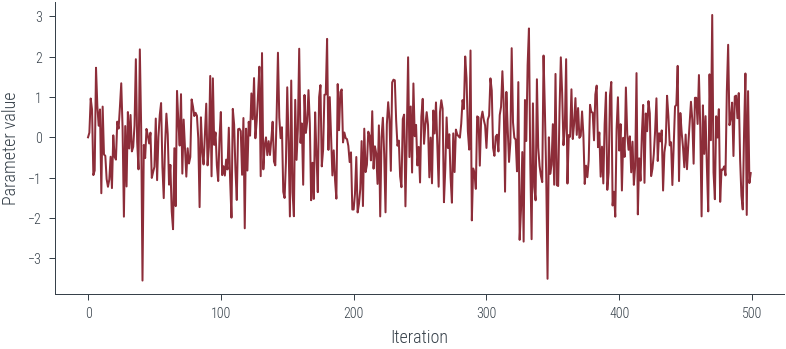

In [50]:
# view first 500 samples
plt.plot(params_hmc[:500], label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')


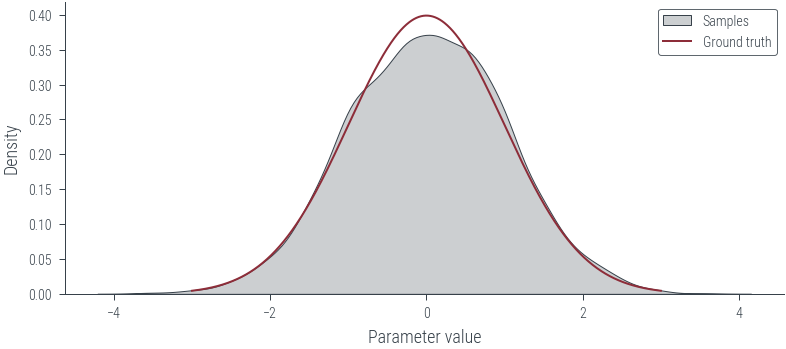

In [25]:
# KDE plot
import seaborn as sns
plt.figure()
sns.kdeplot(params_hmc.detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Ground truth')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()

In [69]:
def plot_samples_gif(x_lin, y_lin, params_hmc, filename, frames=50):
    fig, ax = plt.subplots()
    plt.plot(x_lin, y_lin, label='Ground truth')
    scatter = ax.scatter([], [], color='C1', marker='x', s=100)

    # Function to update the animation
    def update(frame):
        scatter.set_offsets(np.array([[params_hmc[frame], 0]]))
        return scatter,

    # Create the animation
    anim = FuncAnimation(fig, update, frames=frames, blit=True)

    # Save the animation as a GIF or video file (you can change the filename and format)
    anim.save(filename, dpi=200)

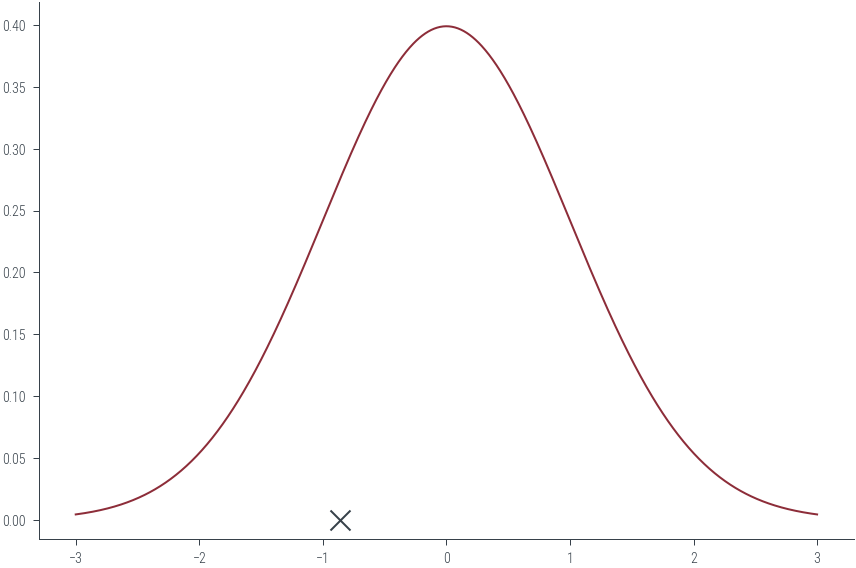

In [61]:
plot_samples_gif(x_lin, y_lin, params_hmc, '../figures/sampling/mcmc/hamiltorch-samples-normal.gif')

![](../figures/sampling/mcmc/hamiltorch-samples-normal.gif)

<AxesSubplot:ylabel='Density'>

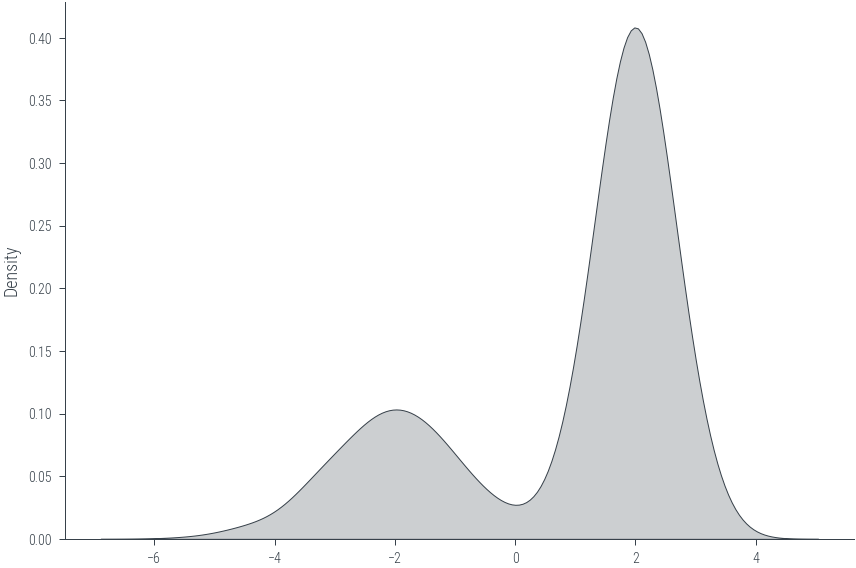

In [62]:
# sample from Mixture of Gaussians

mog = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(torch.tensor([0.3, 0.7])),
    component_distribution=dist.Normal(torch.tensor([-2.0, 2.0]), torch.tensor([1.0, 0.5]))
)

samples = mog.sample((1000,))
sns.kdeplot(samples.numpy(), label='Samples', shade=True, color='C1')

In [63]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return mog.log_prob(x)

logprob(torch.tensor([0.0]))

tensor([-4.1114])

In [64]:
# Initial state
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                 num_samples=num_samples, step_size=step_size,
                                 num_steps_per_sample=num_steps_per_sample)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 456.57       
Acceptance Rate 0.99


In [65]:
params_hmc = torch.tensor(params_hmc)


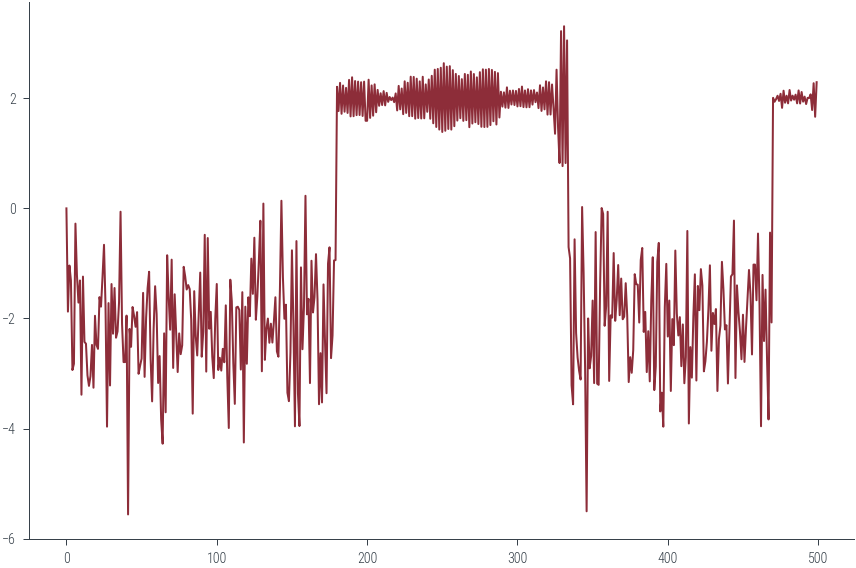

In [66]:
# Trace plot
plt.plot(params_hmc[:500], label='Trace')

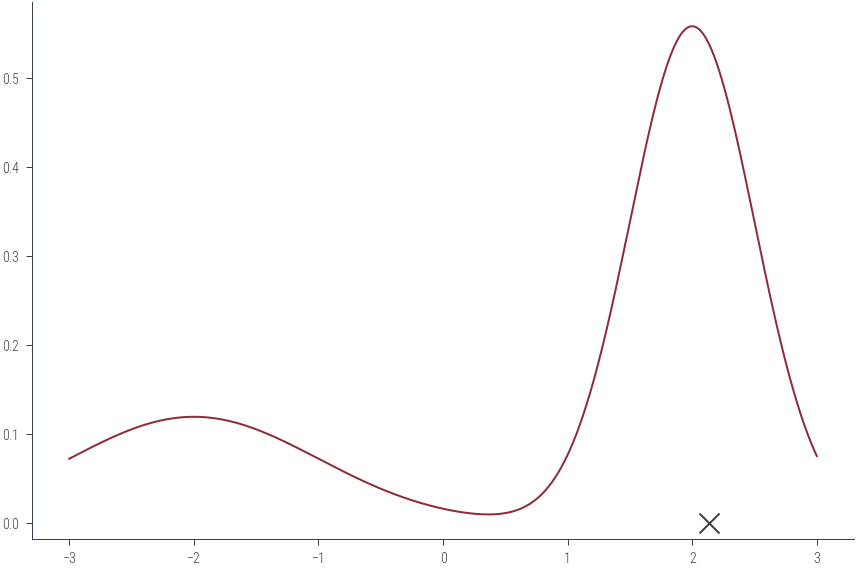

In [70]:
y_lin = torch.exp(mog.log_prob(x_lin))
plot_samples_gif(x_lin, y_lin, params_hmc, '../figures/sampling/mcmc/hamiltorch-samples-mog.gif', frames=300)

In [71]:
def p_tilde(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2*np.pi))
    return dist.Normal(0, 1).log_prob(x).exp()*Z

def p_tilde_log_prob(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2*np.pi))
    return dist.Normal(0, 1).log_prob(x) + torch.log(Z)

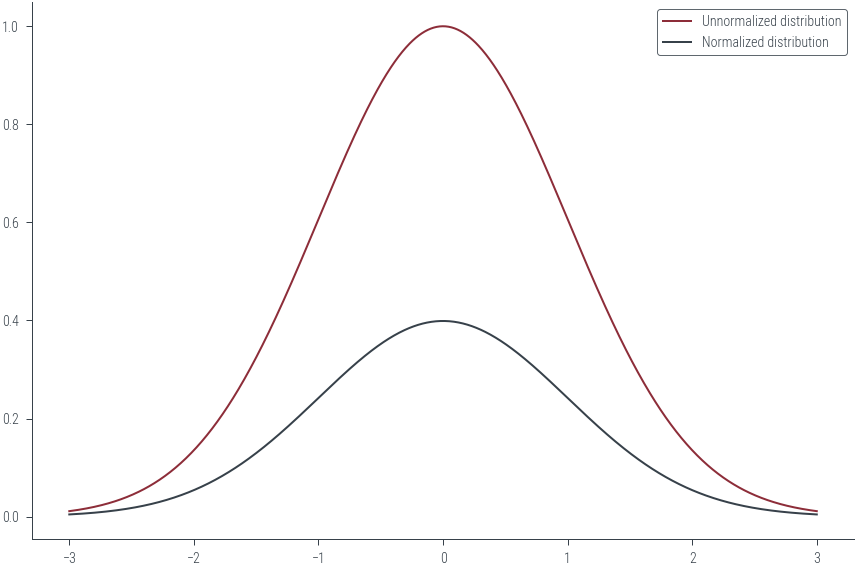

In [73]:
# Plot unnormalized distribution
x_lin = torch.linspace(-3, 3, 1000)
y_lin = p_tilde(x_lin)
plt.plot(x_lin, y_lin, label='Unnormalized distribution')
# Plot normalized distribution
plt.plot(x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label='Normalized distribution')
plt.legend()

In [74]:
# HMC over unnormalized distribution

# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return p_tilde_log_prob(x)


tensor([0.])

In [75]:
# HMC
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                    num_samples=num_samples, step_size=step_size,
                                    num_steps_per_sample=num_steps_per_sample)

params_hmc = torch.tensor(params_hmc)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 477.15       
Acceptance Rate 0.99


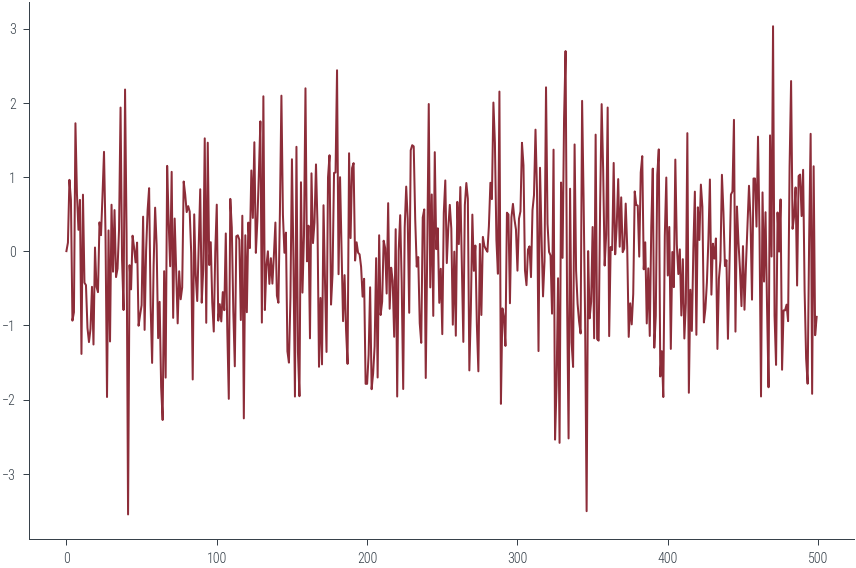

In [76]:
# Trace plot
plt.plot(params_hmc[:500], label='Trace')

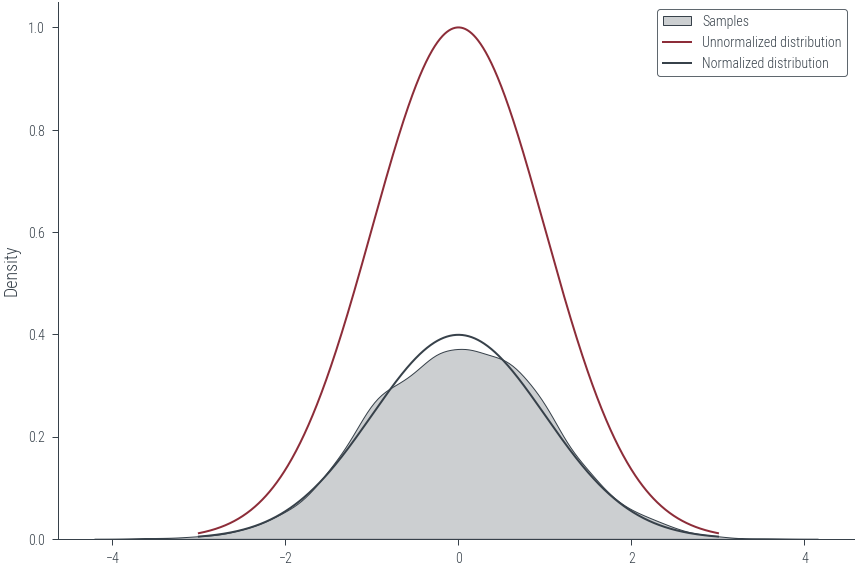

In [77]:
# KDE plot
sns.kdeplot(params_hmc.detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Unnormalized distribution')
plt.plot(x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label='Normalized distribution')
plt.legend()

In [81]:
# Coin toss

prior = dist.Beta(1, 1)
data = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0])
n = len(data)

def log_prior(theta):
    return prior.log_prob(theta)

def log_likelihood(theta):
    return dist.Bernoulli(theta).log_prob(data).sum()

def negative_log_joint(theta):
    return (log_prior(theta) + log_likelihood(theta))


In [103]:
def run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample):
    params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                    num_samples=num_samples, step_size=step_size,
                                    num_steps_per_sample=num_steps_per_sample)
    return torch.stack(params_hmc)



In [104]:
try:
    params_hmc_theta = run_hmc(negative_log_joint, torch.tensor([0.5]), 5000, 0.3, 5)
except Exception as e:
    print(e)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:16 | 0d:00:00:00 | #################### | 5000/5000 | 305.55       
Acceptance Rate 0.99


In [105]:
# Let us work instead with logits
def log_prior(logits):
    return prior.log_prob(torch.sigmoid(logits)).sum()

def log_likelihood(logits):
    return dist.Bernoulli(logits=logits).log_prob(data).sum()

def log_joint(logits):
    return (log_prior(logits) + log_likelihood(logits))

In [118]:
params_hmc_logits = run_hmc(log_joint, torch.tensor([0.0]), 1000, 0.3, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 270.44       
Acceptance Rate 0.99


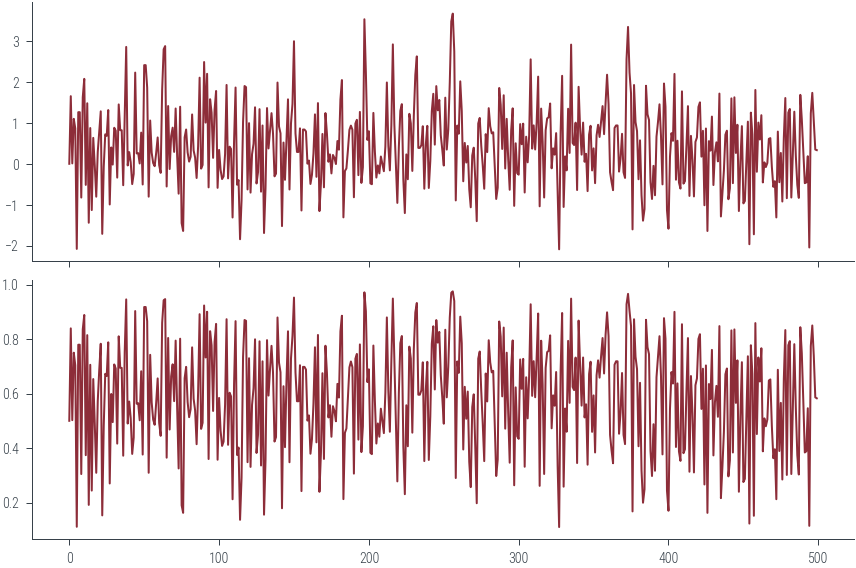

In [119]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(params_hmc_logits[:500], label='Trace')
ax[1].plot(torch.sigmoid(params_hmc_logits[:500]), label='Trace')

In [120]:
params_hmc_logits[:, 0]

tensor([ 0.0000e+00,  1.6534e+00,  9.6122e-03,  1.0988e+00,  8.6559e-01,
        -2.0808e+00,  1.2617e+00,  1.2617e+00, -8.2547e-01,  1.6278e+00,
         2.0763e+00, -5.1573e-01,  1.4796e+00, -1.4413e+00,  8.7425e-01,
        -1.1314e+00,  6.3342e-01, -3.6684e-02, -8.0399e-01,  2.9092e-01,
         7.8311e-01,  1.2826e+00, -1.7128e+00, -7.3525e-02,  7.2005e-01,
         6.8356e-01,  1.3137e+00, -9.9467e-01,  3.9936e-01, -1.9222e-02,
         8.8107e-01,  8.0997e-01, -3.3786e-01,  1.4515e+00,  8.2083e-01,
         8.2083e-01, -5.2393e-01,  1.1097e+00,  2.8575e+00, -3.9971e-02,
         2.8476e-01,  4.0993e-02, -4.9601e-01, -2.4742e-01,  2.2298e+00,
         2.5214e-01,  2.6092e-01,  7.6723e-03,  7.6258e-01, -5.0583e-01,
         2.4118e+00,  2.4118e+00,  1.8629e+00, -8.0357e-01,  1.0577e+00,
         2.7093e-01,  1.7729e-02, -5.8743e-02,  2.6657e-01,  6.4403e-01,
        -3.1467e-02, -2.2159e-01,  1.8147e+00,  2.7993e+00,  2.8776e+00,
        -5.5522e-01,  1.4121e+00, -1.2795e-01,  6.7

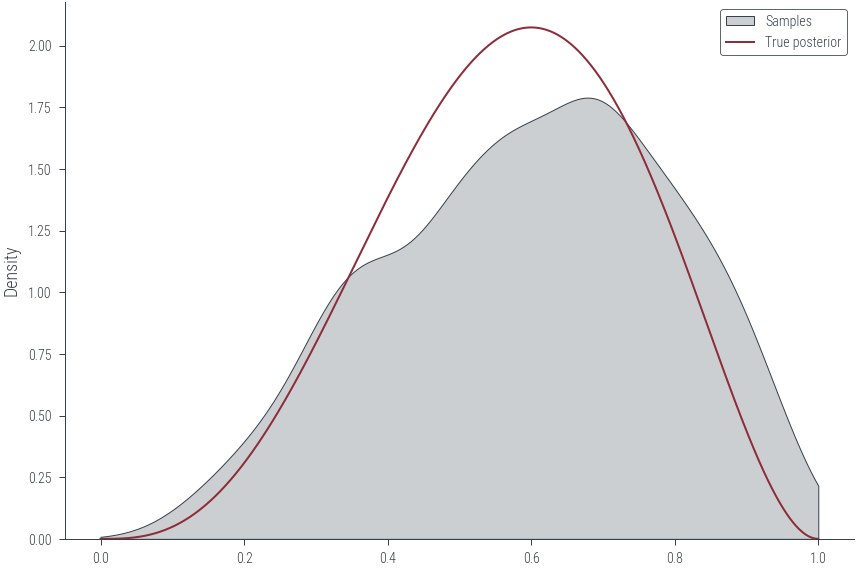

In [124]:
# Plot posterior KDE using seaborn but clip to [0, 1]
sns.kdeplot(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), label='Samples', shade=True, color='C1', clip=(0, 1))
# True posterior
x_lin = torch.linspace(0, 1, 1000)
y_lin = dist.Beta(1+3, 1+2).log_prob(x_lin).exp()
plt.plot(x_lin, y_lin, label='True posterior')
plt.legend()

Text(0, 0.5, 'y')

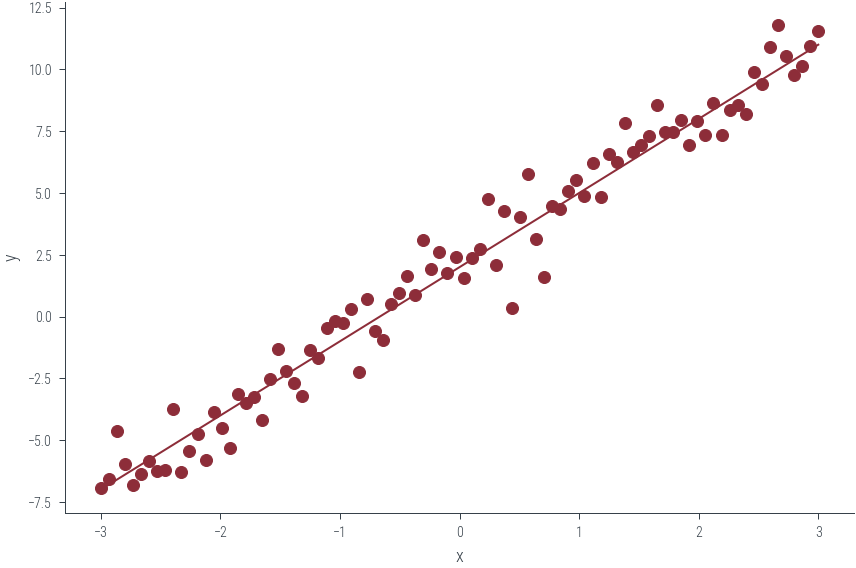

In [129]:
# Linear regression for 1 dimensional input using HMC

x_lin = torch.linspace(-3, 3, 90)
theta_0_true = torch.tensor([2.0])
theta_1_true = torch.tensor([3.0])
f = lambda x: theta_0_true + theta_1_true * x
eps = torch.randn_like(x_lin) *1.0
y_lin = f(x_lin) + eps

plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth')
plt.xlabel('x')
plt.ylabel('y')

In [130]:
# Esimate theta_0, theta_1 using HMC assuming noise variance is known to be 1
def logprob(theta):
    y_pred = theta[0] + x_lin * theta[1]
    return dist.Normal(y_pred, 1).log_prob(y_lin).sum()

def log_prior(theta):
    return dist.Normal(0, 1).log_prob(theta).sum()

def log_posterior(theta):
    return logprob(theta) + log_prior(theta)

In [134]:
params_hmc_lin_reg = run_hmc(log_posterior, torch.tensor([0.0, 0.0]), 1000, 0.1, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 284.26       
Acceptance Rate 0.85


In [135]:
params_hmc_lin_reg

tensor([[0.0000, 0.0000],
        [1.8746, 0.4487],
        [2.0435, 5.3350],
        ...,
        [2.0767, 3.0283],
        [2.0767, 3.0283],
        [2.0224, 3.0637]])

In [ ]:
par

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


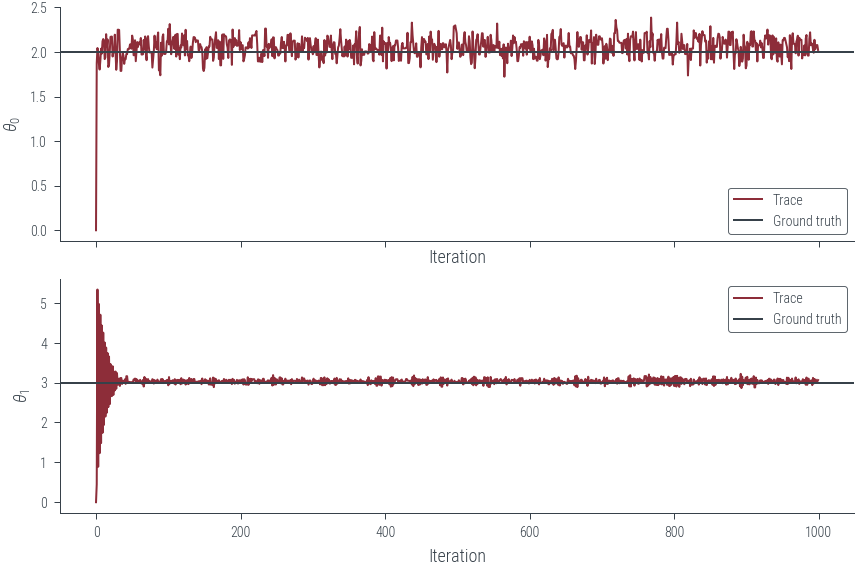

In [137]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc_lin_reg.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axhline(param_vals.numpy(), color='C1', label='Ground truth')
    axes[i].legend()

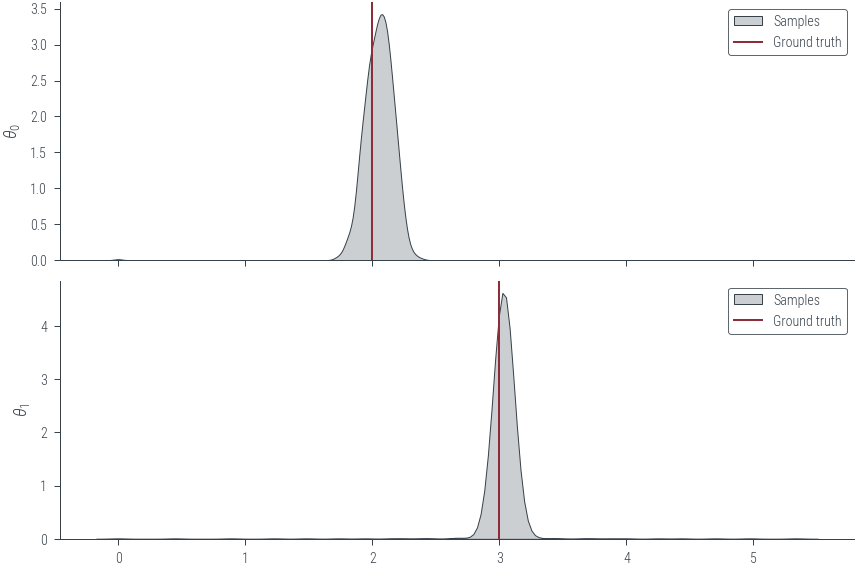

In [140]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc_lin_reg.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axvline(param_vals.numpy(), color='C0', label='Ground truth')
    axes[i].legend()

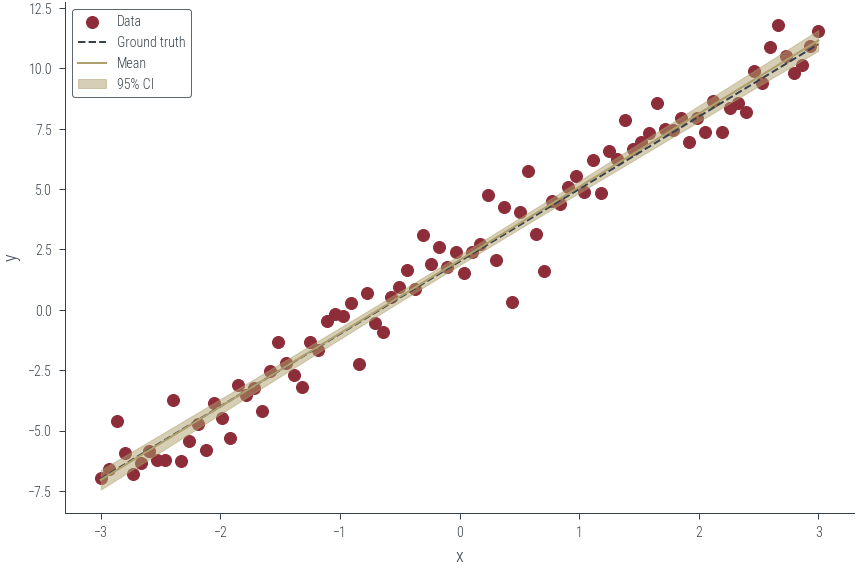

In [141]:
# Plot the posterior predictive distribution
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc_lin_reg[100:].detach()
y_hat = posterior_samples[:, 0].unsqueeze(1) + x_lin * posterior_samples[:, 1].unsqueeze(1)

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.mean(axis=0), label='Mean', color='C2')
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * y_hat.std(axis=0), y_hat.mean(axis=0) + 2 * y_hat.std(axis=0), alpha=0.5, label='95% CI', color='C2')
plt.legend()

In [153]:
# Using a neural network with HMC

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x



In [154]:
net = Net()
net

Net(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)

In [155]:
hamiltorch.util.flatten(net).shape

torch.Size([2])

In [156]:
theta_params = hamiltorch.util.flatten(net)
theta_params

tensor([ 0.9845, -0.2580], grad_fn=<CatBackward0>)

In [178]:
hamiltorch.util.unflatten(net, theta_params)

[tensor([[0.9845]], grad_fn=<ViewBackward0>),
 tensor([-0.2580], grad_fn=<ViewBackward0>)]

In [158]:
params_init = theta_params.clone().detach()
params_init

tensor([ 0.9845, -0.2580])

In [173]:
def log_prior(theta):
    return dist.Normal(0, 10).log_prob(theta).sum()

def log_likelihood(theta):
    y_pred = net(x_lin.unsqueeze(1))
    return dist.Normal(y_pred, 1).log_prob(y_lin).sum()

def log_joint(theta):
    return log_prior(theta) + log_likelihood(theta)

params_hmc = run_hmc(log_joint, params_init, 1000, 0.1, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 300.63       
Acceptance Rate 1.00


In [174]:
params_hmc

tensor([[  0.9845,  -0.2580],
        [  1.5989,   0.5373],
        [  2.3423,   1.0208],
        ...,
        [-13.5197,  -1.8655],
        [-13.3705,  -2.1247],
        [-12.4932,  -2.1522]])

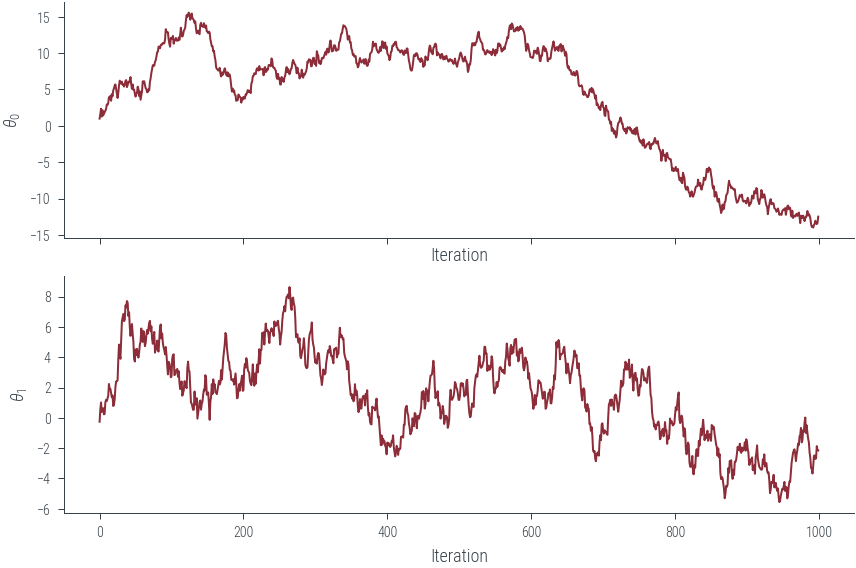

In [175]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')



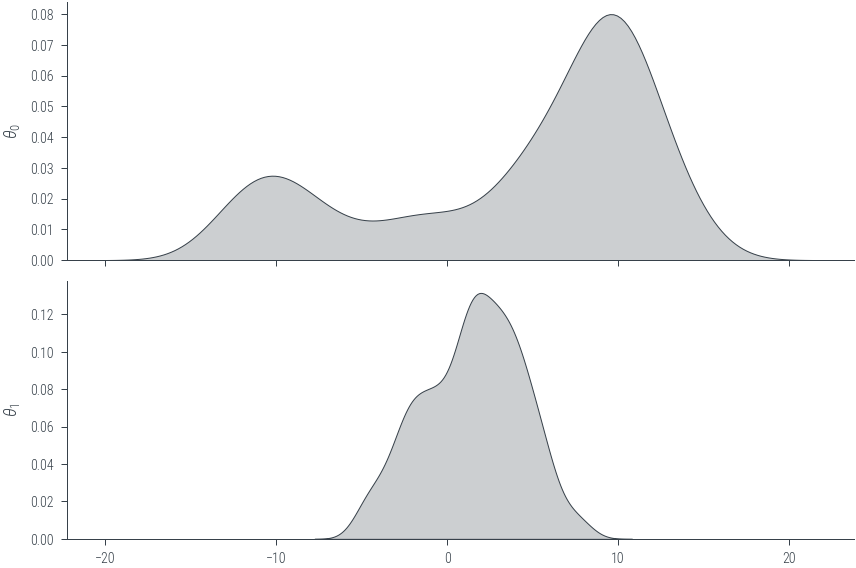

In [176]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')


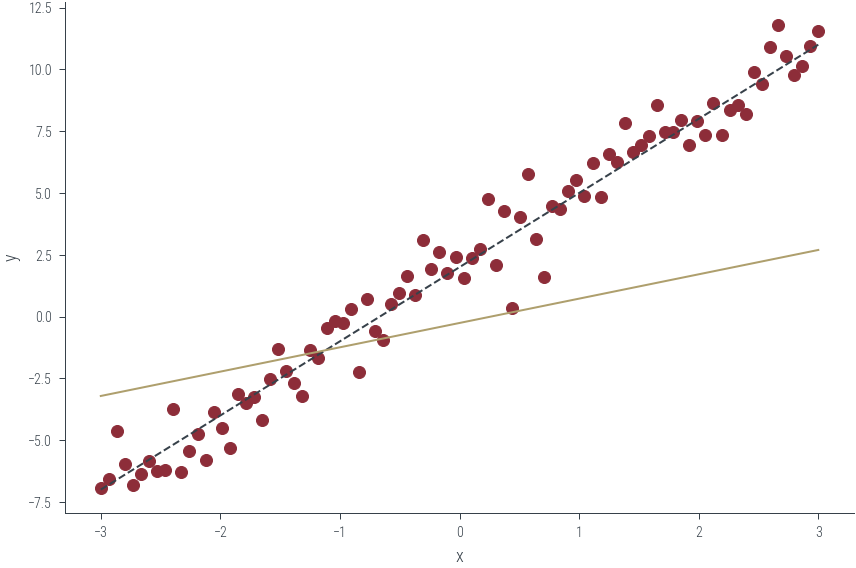

In [177]:
# Plot predictions
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc[100:].detach()
with torch.no_grad():
    y_hat = net(x_lin.unsqueeze(1))

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.ravel(), label='Mean', color='C2')


In [171]:
y_hat.ravel()

tensor([-3.2116, -3.1452, -3.0788, -3.0125, -2.9461, -2.8797, -2.8134, -2.7470,
        -2.6806, -2.6142, -2.5479, -2.4815, -2.4151, -2.3488, -2.2824, -2.2160,
        -2.1496, -2.0833, -2.0169, -1.9505, -1.8841, -1.8178, -1.7514, -1.6850,
        -1.6187, -1.5523, -1.4859, -1.4195, -1.3532, -1.2868, -1.2204, -1.1541,
        -1.0877, -1.0213, -0.9549, -0.8886, -0.8222, -0.7558, -0.6895, -0.6231,
        -0.5567, -0.4903, -0.4240, -0.3576, -0.2912, -0.2248, -0.1585, -0.0921,
        -0.0257,  0.0406,  0.1070,  0.1734,  0.2398,  0.3061,  0.3725,  0.4389,
         0.5052,  0.5716,  0.6380,  0.7044,  0.7707,  0.8371,  0.9035,  0.9699,
         1.0362,  1.1026,  1.1690,  1.2353,  1.3017,  1.3681,  1.4345,  1.5008,
         1.5672,  1.6336,  1.6999,  1.7663,  1.8327,  1.8991,  1.9654,  2.0318,
         2.0982,  2.1646,  2.2309,  2.2973,  2.3637,  2.4300,  2.4964,  2.5628,
         2.6292,  2.6955])

In [ ]:
# Now, solve the above using Hamiltorch's MCMC sample_model function

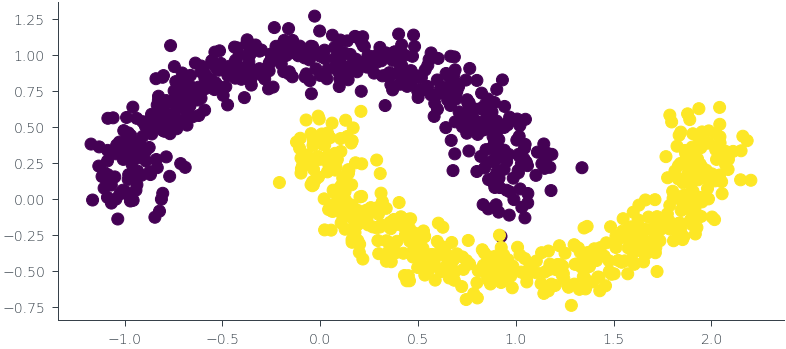

In [38]:
### Bayesian Logistic Regression

from sklearn.datasets import make_moons

# Generate data
x, y = make_moons(n_samples=1000, noise=0.1, random_state=0)

plt.scatter(x[:, 0], x[:, 1], c=y)

x = torch.tensor(x).float()
y = torch.tensor(y).float()